In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import numpy as np

In [2]:

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataset = ImageFolder('EuroSAT_RGB', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, len(dataset.classes)),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    print("Epoch:", epoch)
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('Training finished!')

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Training finished!


Overall Test-set Accuracy: 0.85


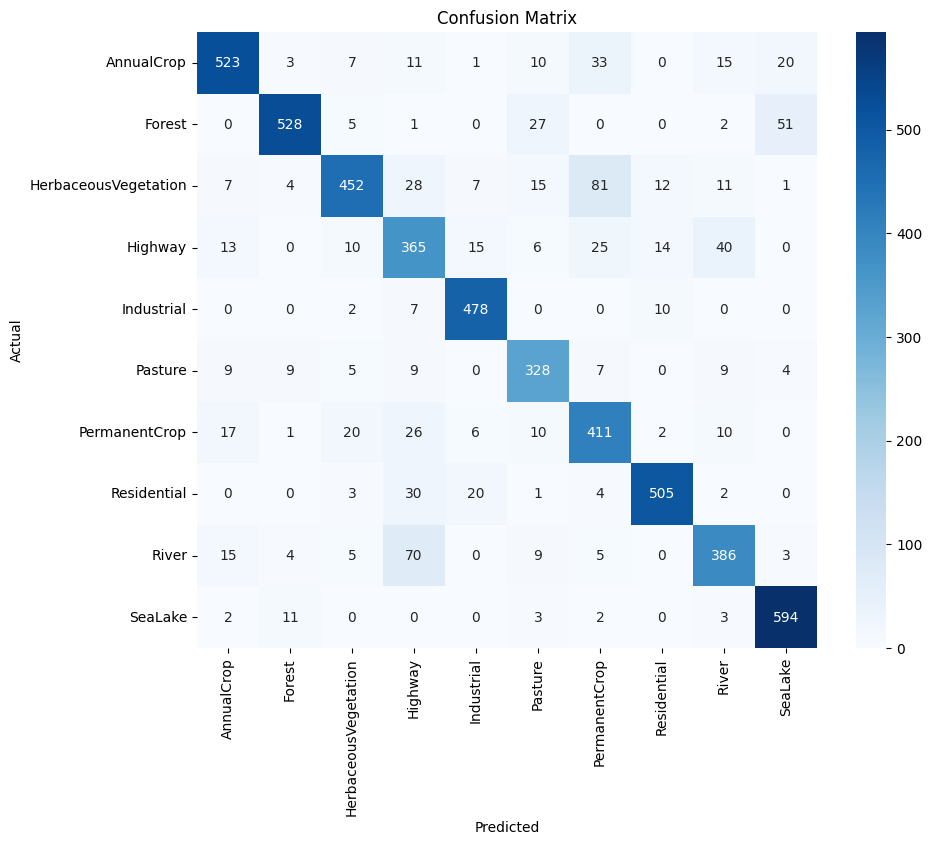

In [13]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Test-set Accuracy: {accuracy:.2f}')


conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(len(dataset.classes))))


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


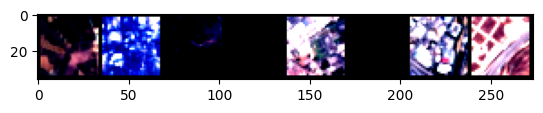

Labels: 6 4 2 9 4 9 4 3


In [16]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of test images and display them
iterate_image = iter(test_loader)
images, labels = next(iterate_image)

imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(8)))